In [1]:
import pprint
from time import sleep

In [2]:
from functools import partial
import polars as pl
from polars import Int8, Float32
from numpy.random import uniform
from openseespy.opensees import *
import matplotlib.pyplot as plt
import numpy as np

In [90]:
def initialize_truss(properties):
    """
    Initializes a cantilever cross-bracing truss beam model using OpenSeesPy.
    The truss structure is modeled in 2D with a set of nodes and truss elements 
    (bars) connecting them. The model represents a cantilever beam with 
    diagonal cross braces. The nodes and elements are indexed according to 
    the following diagram:

       (9)        (7)         (5)         (3)         (1)
      ▷o----1-----o-----2----o-----3-----o-----4----o
          13    ⟋  | 15     ⟋ | 17     ⟋ | 19     ⟋ |
            ⟍ ⟋    |   ⟍ ⟋   |    ⟍ ⟋   |    ⟍ ⟋   |
            ⟋ ⟍    9   ⟋ ⟍   10   ⟋ ⟍   11   ⟋ ⟍   12
          14    ⟍  | 16     ⟍ | 18     ⟍ | 20     ⟍ |
      ▷o----5-----o-----6----o-----7-----o----8-----o
       (10)       (8)         (6)         (4)         (2)

    The structure is defined by a series of 'cells' composed of vertical, horizontal, 
    and diagonal truss elements. The model can be customized using the 
    'properties' parameter to set up materials, dimensions, and element attributes.

    Key modeling assumptions:
    - 2D model with 2 degrees of freedom per node (translations in x and y).
    - Linear elastic behavior for all materials, defined by 'E' (Young's Modulus).

    Parameters:
    -----------
    properties : dict
        A dictionary containing the following fields:
        - name: str
            Name of the truss structure model.
        - cell_length: float
            Length of each horizontal truss element (L).
        - cell_height: float
            Height of each vertical truss element (H).
        - cell_number: int
            Number of cells in the truss.
        - materials: list of dict
            List of materials with 'tag' and 'E' values where:
            - 'tag': int, identifier for each material.
            - 'E': float, Young's Modulus for the material.
        - bars_material: dict
            A dictionary where the key is the element tag and the value is the 
            material tag for the corresponding truss element.
        - bars_A: dict
            A dictionary where the key is the element tag and the value is the 
            cross-sectional area (A) for the corresponding truss element.
        - nodes_load: dict
            A dictionary where the key is the node number and the value is a dict 
            containing applied loads in x and y directions for that node:
            - 'x': float, load applied in the x direction.
            - 'y': float, load applied in the y direction.

    Notes:
    ------
    1. This function assumes all necessary OpenSeesPy classes and functions have 
       been imported, using the statement:
       >> from openseespy.opensees import *
    2. The truss elements are created using the 'Truss' element type with the 
       defined cross-sectional areas and material properties.
    3. The node numbering follows a specific pattern, ensuring consistent 
       connections between the elements.

    Example:
    --------
    Example of valid 'properties' input:

    properties = {
        'name': "reference_truss",
        'cell_length': 4,
        'cell_height': 4,
        'cell_number': 2,
        'materials': [
            {'tag': 1, 'E': 1000},
            {'tag': 2, 'E': 2000},
            {'tag': 3, 'E': 3000},
        ],
        'bars_material': {
            1: 1, 2: 1, 3: 2, 4: 2, 5: 1, 6: 1, 7: 3, 8: 3, 9: 3, 10: 3
        },
        'bars_A': {
            1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10, 10: 10
        },
        'nodes_load': {
            1: {'x': 0, 'y': 0}, 2: {'x': 0, 'y': 0}, 3: {'x': 0, 'y': 0},
            4: {'x': 0, 'y': 0}, 5: {'x': 0, 'y': 0}, 6: {'x': 0, 'y': 0}
        }
    }

    The model is automatically cleared before defining a new one.
    """  
    
    # Model

    ## Clearing the model
    wipe()
    model('basic', '-ndm', 2, '-ndf', 2)
    
    ## Model materials
    for material in properties['materials']:
        uniaxialMaterial('Elastic', material['tag'], material['E'])

    ## Geometry
    ### Create nodes
    cell_number = properties['cell_number']
    L = properties['cell_length']
    H = properties['cell_height']
    
    for i in range(cell_number + 1):
        node(2*i + 1, i*L,  .5*H)
        node(2*i + 2, i*L, -.5*H)

    ### Create bars
    bars_A = properties['bars_A']
    bars_material = properties['bars_material']
    
    #### Top horizontal bars
    for i in range(cell_number):
        tag = i + 1
        A = bars_A[tag]
        material = bars_material[tag]
        element("Truss",   i + 1, *(1+2*i, 3+2*i), A, material) 

    #### Bottom horizontal bars
    for i in range(cell_number):
        tag = cell_number + i + 1
        A = bars_A[tag]
        material = bars_material[tag]
        element("Truss", cell_number + i + 1, *(2+2*i, 4+2*i), A, material) 

    #### Vertical bars
    for i in range(cell_number):
        tag = 2*cell_number + i + 1
        A = bars_A[tag]
        material = bars_material[tag]
        element("Truss", 2*cell_number + i + 1, *(2*i+3, 2*i + 4), A, material) 

    #### S-O to N-E diagonal bars
    for i in range(cell_number):
        tag = 3*cell_number + 2*i + 1
        A = bars_A[tag]
        material = bars_material[tag]
        element("Truss", 3*cell_number + 2*i + 1, *(2*i+1, 2*i+4), A, material) 

    #### S-E to N-O diagonal bars
    for i in range(cell_number):
        tag = 3*cell_number + 2*i + 2
        A = bars_A[tag]
        material = bars_material[tag]
        element("Truss", 3*cell_number + 2*i + 2, *( 2*(i+1), 2*(i+1) + 1), A, material) 

    ## Boundary condition
    ### Supports
    fix(1, *(1,1))
    fix(2, *(1,1))

    ### Loads
    timeSeries('Constant', 1)
    pattern("Plain", 1, 1)
    for index, load_i in properties['nodes_load'].items():
        if load_i['x'] == 0 and load_i['y'] == 0: continue
        load(index, load_i['x'], load_i['y'])

In [91]:
properties = {
    'name': "reference_truss",
    'cell_length': 4, # m
    'cell_height': 4, # m
    'cell_number': 2,
    'materials': [
        {'tag': 1, 'E': 200e9}, # N/m^2
        {'tag': 2, 'E': 200e9}, # N/m^2
        {'tag': 3, 'E': 200e9}, # N/m^2
        {'tag': 4, 'E': 200e9}, # N/m^2
    ],
    'bars_material': {
        1: 1,
        2: 1,
        3: 2,
        4: 2,
        5: 3,
        6: 3,
        7: 4,
        8: 4,
        9: 4,
        10: 4
    },
    'bars_A': {
        1: 0.004, # m^2
        2: 0.004, # m^2
        3: 0.004, # m^2
        4: 0.004, # m^2
        5: 0.004, # m^2
        6: 0.004, # m^2
        7: 0.004, # m^2
        8: 0.004, # m^2
        9: 0.004, # m^2
        10: 0.004 # m^2
    },
    'nodes_load':{
        1: {'x':10e3, 'y':-10e3}, # N
        2: {'x':0, 'y':0}, # N
        3: {'x':0, 'y':0}, # N
        4: {'x':0, 'y':-10000}, # N
        5: {'x':0, 'y':0}, # N
        6: {'x':0, 'y':-10000}  # N
    }
}

In [92]:
getNodeTags()

[1, 2, 3, 4, 5, 6]

In [97]:
def __plot_node(ax, coordinates, r, color='black'):
    node = plt.Circle(coordinates, radius=r, color=color)
    ax.add_patch(node)

def __annotate_node(ax, coordinates, tag, offset=0., color='black'):
    coordinates = [xi + offset for xi in coordinates]
    ax.annotate(tag, coordinates, color=color, fontweight="semibold")

def __annotate_element(ax, x, y, tag, offset=0., color='black'):
    coordinates = [x[1] + .3 * (x[0] - x[1]), y[1] + .3 * (y[0] - y[1])]
    coordinates = [xi + offset for xi in coordinates]
    ax.annotate(tag, coordinates, color=color)
              
def plot(ax=None,
         support=True,
         node_label=True, elem_label=True, dimension=True,
         line_color='black', line_style='--', line_width=1,
         deformed=True, deformed_line_color='red', deformed_line_style='-', deformed_line_width=1,
         scale_factor=50):
    
    # Create axis if not given    
    if ax is None: 
        _, ax=plt.subplots()
        ax.set_aspect('equal', 'box')
    
    # Get undisplaced nodes coordinates
    node_coords = {node_tag: osp.nodeCoord(node_tag) for node_tag in osp.getNodeTags()}
    
    # Get displaced node coordinates
    disp_coords = {node_tag: 
                   [
                       osp.nodeCoord(node_tag)[0] + osp.nodeDisp(node_tag, 1) * scale_factor, 
                       osp.nodeCoord(node_tag)[1] + osp.nodeDisp(node_tag, 2) * scale_factor
                   ]
                   for node_tag in osp.getNodeTags()
                  }
    
    # Get connectivity matrix
    connectivity = {elem_tag: osp.eleNodes(elem_tag) for elem_tag in osp.getEleTags()}

    # Plot underformed shape
    for tag, nodes in connectivity.items():
        x = [node_coords[node][0] for node in nodes]
        y = [node_coords[node][1] for node in nodes]
        ax.plot(x, y, linestyle=line_style, color=line_color, linewidth=line_width)

        if elem_label:
            __annotate_element(ax, x, y, tag, color=line_color)

    # Plot nodes
    r = np.max([*ax.get_xlim(), *ax.get_ylim()]) * 0.005
    for tag, node_coord in node_coords.items():
        if node_label:
            __annotate_node(ax, node_coord, tag, offset=r, color=line_color)
        __plot_node(ax, node_coord, r, color=line_color)

    # Plot deformed shape
    if deformed:
        for tag, nodes in connectivity.items():
            x = [disp_coords[node][0] for node in nodes]
            y = [disp_coords[node][1] for node in nodes]
            ax.plot(x, y, linestyle=deformed_line_style, color=deformed_line_color, linewidth=deformed_line_width)

        # Plot nodes
        for node_coord in disp_coords.values():
            __plot_node(ax, node_coord, r, color=deformed_line_color)
                
    return ax

In [94]:
def run_linear_analysis():
    # create SOE
    system("BandSPD")
    
    # create DOF number
    numberer("RCM")
    
    # create constraint handler
    constraints("Plain")
    
    # create integrator
    integrator("LoadControl", 1.0)
    
    # create algorithm
    algorithm("Linear")
    
    # create analysis object
    analysis("Static")
    
    # perform the analysis
    analyze(1)

In [95]:
# Generation of full random dataset
"""
Generate the dataset.
Generator function must include an argument named "size".
"""
def dataset_generator(size,
                      H_range=partial(uniform, 7.5, 12.5), 
                      L_range=partial(uniform, 7.5, 12.5),
                      load_range=partial(uniform, -750e3, 750e3), load_unique=False,
                      load_trigger=lambda:[True, True, True, True, True, True, True, True, True, True, True, True],
                      area_range=partial(uniform, 1e-3, 5e-2), area_unique=False,
                      young_range=partial(uniform, 50e9, 250e9), young_unique=False):
    """
    The first phase of the master thesis is dedicated to modeling the expected behaviour on a 
    simplified case. We will consider a cross-bracing truss beam model with two cells.
    
    Multiple variation will be generated and analyse to create a dataset. This dataset will 
    contain the following 68 features:

    n: int
        Number of cells
    
    H, L: float64
        Respectively the length of vertical and horizontal bars in meters.
    
    x1, y1, x2, y2, x3, y3, x4, y4, x5, y5, x6, y6: float64
        The undeformed location of each 6 nodes in meters.
    
    P_x1, P_y1, P_x2, P_y2, P_x3, P_y3, P_x4, P_y4, P_x5, P_y5, P_x6, P_y6: float64
        The force applied to each 6 nodes in newtons.
    
    E_1, E_2, E_3, E_4, E_5, E_6, E_7, E_8, E_9, E_10: float64
        The young modulus of the material of each bar in pascals.
    
    A_1, A_2, A_3, A_4, A_5, A_6, A_7, A_8, A_9, A_10: float64
        The gross cross-section of each bar in meter squared.
    
    u_x1, u_y1, u_x2, u_y2, u_x3, u_y3, u_x4, u_y4, u_x5, u_y5, u_x6, u_y6: float64
        The displacement of each nodes in meters.
    
    N_1, N_2, N_3, N_4, N_5, N_6, N_7, N_8, N_9, N_10: float64
        The axial forces in each bar in newtons.
    """
    for k in range(size):
        cell_length = L_range()
        cell_height = H_range()

        areas = np.full(10, area_range()) if area_unique else area_range(size=10)
        bars_area = {i+1:areas[i] for i in range(10)}

        youngs = np.full(10, young_range()) if young_unique else young_range(size=10)
        materials = [{'tag': i+1, 'E':youngs[i]} for i in range(10)]
        
        loads = np.full((6,2), load_range(size=(1,2))) if load_unique else load_range(size=(6,2))
        for i, trigger in enumerate(load_trigger()):
            if not trigger: loads[i//2][i%2] = 0.
                
        nodes_load = {i+1:{'x': loads[i][0], 'y': loads[i][1]} for i in range(6)}
    
        properties = {
            'name': f"truss_{i}",
            'cell_length': cell_length, # m
            'cell_height': cell_height, # m
            'cell_number': 2,
            'materials': materials,
            'bars_material': {i:i for i in range(1,11)},
            'bars_A': bars_area,
            'nodes_load':nodes_load
        }
        initialize_truss(properties)
        run_linear_analysis()

        u = [u_i for tag in getNodeTags() for u_i in nodeDisp(tag)]
        forces = [n_i for tag in getEleTags() for n_i in eleResponse(tag, "basicForce")]

        row = [2, cell_height, cell_length]
        # Nodes locations
        _ = [nodeCoord(node_tag) for node_tag in range(1, 7)]
        row += [vi for v in _ for vi in v]
        
        # Loads on nodes
        #_ = [nodes_load[i] for i in range(1,7)]
        row += [pi for p in loads for pi in p]

        # Young modulus
        row += list(youngs) #[young['E'] for young in youngs]

        # Area
        row += list([areas[i] for i in range(10)])

        # Node displacement
        row += u

        # Forces
        row += forces
        yield row

def f1(size): E1, E2, E3 = uniform(50e9, 250e9, size=3); return [E1, E1, E1, E1, E2, E2, E3, E3, E3, E3];
def f2(size): A1, A2, A3 = uniform(1e-4, 5e-2, size=3); return [A1, A1, A1, A1, A2, A2, A3, A3, A3, A3];

generator = dataset_generator(100,
                              H_range=partial(uniform, 2.5, 17.5), 
                              L_range=partial(uniform, 2.5, 17.5),
                              load_range=partial(uniform, -1000e3, 0), load_unique=True,
                              load_trigger=lambda:[False, False, False, True, False, False, False, True, False, False, False, False],
                              area_range=f1,
                              young_range=f2)

lf = pl.LazyFrame(generator, schema=
                  {
                      'n_cells':Int8, 'cell_height':Float32, 'cell_length':Float32, 
                      'x1':Float32, 'y1':Float32, 'x2':Float32, 'y2':Float32, 'x3':Float32, 'y3':Float32, 
                      'x4':Float32, 'y4':Float32, 'x5':Float32, 'y5':Float32, 'x6':Float32, 'y6':Float32,
                      'P_x1':Float32, 'P_y1':Float32, 'P_x2':Float32, 'P_y2':Float32, 'P_x3':Float32, 'P_y3':Float32, 
                      'P_x4':Float32, 'P_y4':Float32, 'P_x5':Float32, 'P_y5':Float32, 'P_x6':Float32, 'P_y6':Float32,
                      'E_1':Float32, 'E_2':Float32, 'E_3':Float32, 'E_4':Float32, 'E_5':Float32, 
                      'E_6':Float32, 'E_7':Float32, 'E_8':Float32, 'E_9':Float32, 'E_10':Float32,
                      'A_1':Float32, 'A_2':Float32, 'A_3':Float32, 'A_4':Float32, 'A_5':Float32, 
                      'A_6':Float32, 'A_7':Float32, 'A_8':Float32, 'A_9':Float32, 'A_10':Float32,
                      'u_x1':Float32, 'u_y1':Float32, 'u_x2':Float32, 'u_y2':Float32, 'u_x3':Float32, 'u_y3':Float32,
                      'u_x4':Float32, 'u_y4':Float32, 'u_x5':Float32, 'u_y5':Float32, 'u_x6':Float32, 'u_y6':Float32,
                      'N_1':Float32, 'N_2':Float32, 'N_3':Float32, 'N_4':Float32, 'N_5':Float32, 
                      'N_6':Float32, 'N_7':Float32, 'N_8':Float32, 'N_9':Float32, 'N_10':Float32,
                  }
                 )
lf.sink_csv("truss_10-Load_2_4-height_2.5_17.5-length_2.5_17.5-young_50e9_250e9_D_H_V-area_0.0001_0.005_D_H_V-1000K.csv", batch_size=100)

#plot(scale_factor=1)

<Axes: >

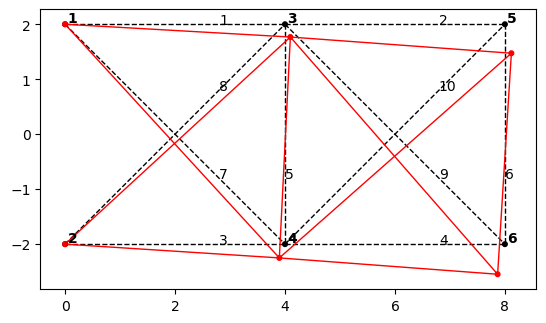

In [96]:
initialize_truss(properties)
run_linear_analysis()
plot(deformed=True,scale_factor=1000)